# Clinical Reasoning Model Benchmarking and Fine-Tuning (MedCalc-Bench)

This notebook benchmarks and fine-tunes Qwen3 models on MedCalc-Bench clinical calculation tasks. It covers: prompt engineering (zero-shot, few-shot, CoT), optional advanced methods, parameter-efficient fine-tuning (LoRA/QLoRA), and category-wise evaluation.

Use this on Google Colab Free Tier or locally. All steps are reproducible and parameter choices are explained.

## Contents
- Setup and data loading
- Prompt engineering: Zero-shot, Few-shot, CoT (+ optional advanced)
- Fine-tuning with LoRA/QLoRA (PEFT)
- Inference and evaluation
- Results visualization and interpretation

Tip: If you are in Colab, switch to T4 GPU in Runtime > Change runtime type.


## Reproducibility and Setup

- Run the setup cell below on Colab Free Tier (T4) or locally.
- This notebook assumes result CSVs are in the repository root and LoRA adapters under `qwen_lora_*/`.
- For full fine-tuning, ensure GPU runtime is enabled.

Parameters and decisions are documented inline before each major block.


In [ ]:
# Non-interactive install for Colab/local
# - -q keeps output terse in notebooks
# - Pin transformers >=4.43.0 for Qwen3 compatibility and latest generate features
# - bitsandbytes enables 8-bit/4-bit loading for memory savings
# - accelerate/peft support device placement and parameter-efficient fine-tuning
!pip install -q --upgrade pip
!pip install -q "transformers>=4.43.0" accelerate peft bitsandbytes datasets evaluate scikit-learn seaborn matplotlib pandas numpy
!pip install -q einops xformers


## Data Loading and Structure

We use MedCalc-Bench with fields: `Patient Note`, `Question`, `Category`, `Relevant Entities` (JSON), `Ground Truth Answer`, `Ground Truth Explanation`.

- Train file: `dataset/train_data.csv`
- Test file: `dataset/test_data.csv`

If you are only reproducing results, skip to the Results section; otherwise load the dataset for fine-tuning/inference.


In [ ]:
from datasets import load_dataset

# Load MedCalc-Bench directly from Hugging Face
dataset = load_dataset("ncbi/MedCalc-Bench-v1.0")

# Split into train/test
train_df = dataset["train"].to_pandas()
test_df = dataset["test"].to_pandas()

# Preview
print("Train data shape:", train_df.shape)
print("Test data shape:", test_df.shape)
#train_df.head()
test_df.head()


In [ ]:
# Explore distribution of output types to guide prompt formatting and parsing logic
# - 'decimal' vs 'integer' steer numeric casting
# - 'date' activates MM/DD/YYYY and gestational age tuple handling
output_types = train_df["Output Type"].unique()
print("Unique Output Types:", output_types)

# Show a representative example per type to sanity-check fields and ranges
for ot in output_types:
    print(f"\nSample for Output Type: {ot}")
    print(train_df[train_df["Output Type"] == ot].iloc[0])


### Selected Models

We evaluate two Qwen3 sizes for compute/accuracy tradeoffs:
- **Qwen3-0.6B**: fast, low VRAM, strong baseline with prompt engineering
- **Qwen3-1.7B**: higher capacity, better reasoning, still Colab-compatible with optimizations


In [ ]:
# Model names mapped to Hugging Face hub identifiers
# Rationale:
# - Two sizes cover speed/accuracy trade-offs and fit on common GPUs (T4/A10)
# - Keeping a dict enables uniform loops for loading/evaluation
model_names = {
    "0.6B": "Qwen/Qwen3-0.6B",
    "1.7B": "Qwen/Qwen3-1.7B",
}

### Model and Tokenizer Loading (Qwen3-0.6B, Qwen3-1.7B)

- Left-padding/truncation for decoder-only models to align attention masks.
- bfloat16 weights if available; `device_map='auto'` to distribute on GPU.
- Loads both models to compare prompt methods fairly.


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

# Load models and tokenizers with settings optimized for decoder-only Qwen3
# Parameter choices and reasoning:
# - padding_side = "left": Enables efficient batching for decoder-only LMs where attention
#   depends on position from the right; avoids shifting attention masks across batch items.
# - truncation_side = "left": Keeps the most recent and typically most relevant context
#   when sequences exceed max length (useful for long patient notes).
# - torch_dtype = torch.bfloat16: Cuts memory roughly in half compared to fp32 while
#   maintaining numerical stability on modern GPUs (A100, T4 w/ emulation). Falls back
#   to fp16 automatically at runtime if bfloat16 is unsupported.
# - device_map = "auto": Automatically places weights on available GPU(s) to prevent OOM
#   and leverages VRAM without manual layer placement.
# - trust_remote_code = True: Required for some community models (like Qwen) that ship
#   custom modeling code; vetted upstream but should be used only with trusted repos.
models, tokenizers = {}, {}
for key, name in model_names.items():
    print(f"Loading {name}...")
    tokenizers[key] = AutoTokenizer.from_pretrained(name)
    tokenizers[key].padding_side = "left"   # left-padding for batched decoder-only generation
    tokenizers[key].truncation_side = "left"  # preserve most recent context under truncation
    models[key] = AutoModelForCausalLM.from_pretrained(
        name,
        torch_dtype=torch.bfloat16,  # memory-efficient weights with stable numerics
        device_map="auto",          # auto-shard across GPU(s) if present
        trust_remote_code=True       # allow model-specific implementations
    )

# Quick check of architectures for sanity (helps ensure correct variant is loaded)
print("Models loaded:")
for key in models:
    print(key, models[key])


### Lightweight Generator Wrapper

- Encodes prompt and generates a short completion.
- Conservative decoding defaults keep outputs concise and reproducible across runs.


In [ ]:
def generate_answer(prompt, model, tokenizer, max_length=32):
    """Lightweight wrapper around generate for quick single-prompt checks.
    - Keeps temperature low to reduce variance while allowing minor exploration.
    - Uses left-padding defaults already set on tokenizer.
    - max_length defaults to 32 to encourage concise answers (e.g., numbers/dates).
    """
    # Tokenize to tensors and place on GPU for faster inference
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

    # Sampling choices:
    # - do_sample=True with temperature=0.3: allows slight exploration while keeping outputs stable
    # - top_p=0.9: nucleus sampling trims tail probabilities to avoid degenerate loops
    # - eos_token_id/pad_token_id: ensure proper early stopping and consistent padding behavior
    outputs = model.generate(
        **inputs,
        max_new_tokens=max_length,   # cap new tokens to keep outputs short and on-task
        do_sample=True,
        temperature=0.3,             # low randomness for reproducible numeric outputs
        top_p=0.9,                   # constrain to high-probability tokens
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.pad_token_id or tokenizer.eos_token_id,
    )

    # Convert token IDs back to string, skipping any special tokens that may appear
    return tokenizer.decode(outputs[0], skip_special_tokens=True)


### Answer Extraction, Parsing, and Validation

- Robust `Answer:` extraction from free-form generations.
- Category-aware parsing (numeric vs. date vs. gestational age tuples).
- Range validation against provided lower/upper limits; this drives accuracy metric.


In [ ]:
# -------------------
# Answer Extraction and Validation Functions
# -------------------
import re
from datetime import datetime
import pandas as pd

def extract_answer_from_output(output_text):
    """Extract the last occurrence of 'Answer:' from model output.
    Rationale: models may emit multiple 'Answer:' lines (e.g., retries or CoT).
    Choosing the last occurrence biases toward the final corrected answer.
    """
    # Find all occurrences of "Answer:"
    answer_matches = re.findall(r'Answer:\s*(.+?)(?:\n|$)', output_text, re.IGNORECASE)
    if answer_matches:
        last_answer = answer_matches[-1].strip()
        # Remove any additional text after a newline just in case
        last_answer = last_answer.split('\n')[0].strip()
        return last_answer
    
    return "N/A"

def parse_answer(answer_str, category):
    """Parse answer string based on category.
    Decisions:
    - Treat 'unknown' and NaN as missing to avoid false positives.
    - For numeric categories, prefer float when decimals present; otherwise cast to int
      to align with evaluation expectations for discrete scores.
    - For dates, standardize to MM/DD/YYYY where possible and support (weeks, days)
      tuples for gestational age style answers.
    """
    if pd.isna(answer_str) or answer_str == "unknown":
        return None
    
    try:
        if category in ["lab", "risk", "physical", "severity", "diagnosis", "dosage"]:
            # These categories typically expect numeric values
            # Check if it's an integer or decimal
            if '.' in str(answer_str):
                return float(answer_str)
            else:
                return int(float(answer_str))
        elif category == "date":
            # First check for (weeks, days) format
            weeks_days_match = re.search(r'\((\d+)\s*weeks?[,\s]*[\'"]?\s*(\d+)\s*days?[\'"]?\)', str(answer_str), re.IGNORECASE)
            if weeks_days_match:
                weeks = int(weeks_days_match.group(1))
                days = int(weeks_days_match.group(2))
                # Return as tuple for exact matching in validation
                return (weeks, days)
            
            # Try to parse various date formats, prioritizing MM/DD/YYYY
            date_formats = [
                "%m/%d/%Y", "%m/%d/%y",  # MM/DD/YYYY, MM/DD/YY
                "%Y-%m-%d", "%Y/%m/%d",  # YYYY-MM-DD, YYYY/MM/DD
                "%d/%m/%Y", "%d/%m/%y",  # DD/MM/YYYY, DD/MM/YY
                "%Y-%m", "%Y", "%m/%Y", "%Y/%m"  # Partial dates
            ]
            for fmt in date_formats:
                try:
                    parsed_date = datetime.strptime(str(answer_str), fmt)
                    return parsed_date.strftime("%m/%d/%Y")  # Standardize to MM/DD/YYYY
                except ValueError:
                    continue
            # If no format matches, try to extract year
            year_match = re.search(r'(\d{4})', str(answer_str))
            if year_match:
                return f"01/01/{year_match.group(1)}"
            return None
        else:
            return answer_str
    except (ValueError, TypeError):
        return None

def validate_answer_range(answer, lower_limit, upper_limit, category):
    """Check if answer falls within the expected range.
    Rationale:
    - Returns False on missing inputs to keep the metric conservative.
    - Numeric categories: inclusive range check after float casting to tolerate
      integer/float formatting differences.
    - Date category: exact tuple match for (weeks, days); otherwise inclusive
      range check on standardized MM/DD/YYYY strings.
    """
    if answer is None or pd.isna(lower_limit) or pd.isna(upper_limit):
        return False
    
    try:
        if category in ["lab", "risk", "physical", "severity", "diagnosis", "dosage"]:
            answer_val = float(answer)
            lower_val = float(lower_limit)
            upper_val = float(upper_limit)
            return lower_val <= answer_val <= upper_val
        elif category == "date":
            # Handle (weeks, days) format - exact match required
            if isinstance(answer, tuple) and len(answer) == 2:
                # This is a (weeks, days) format - check for exact match
                try:
                    # Parse the ground truth to see if it's also in (weeks, days) format
                    gt_weeks_days_match = re.search(r'\((\d+)\s*weeks?[,\s]*[\'"]?\s*(\d+)\s*days?[\'"]?\)', str(lower_limit), re.IGNORECASE)
                    if gt_weeks_days_match:
                        gt_weeks = int(gt_weeks_days_match.group(1))
                        gt_days = int(gt_weeks_days_match.group(2))
                        return answer == (gt_weeks, gt_days)
                    else:
                        # If ground truth is not in (weeks, days) format, no match
                        return False
                except (ValueError, TypeError):
                    return False
            
            # For regular dates, we need to parse them
            try:
                answer_date = datetime.strptime(str(answer), "%m/%d/%Y")
                lower_date = datetime.strptime(str(lower_limit), "%m/%d/%Y")
                upper_date = datetime.strptime(str(upper_limit), "%m/%d/%Y")
                return lower_date <= answer_date <= upper_date
            except ValueError:
                return False
    except (ValueError, TypeError):
        return False
    
    return False

# -------------------
# Enhanced Zero-Shot Prompt with Better Date Handling
# -------------------
def zero_shot_prompt(patient_note, question, entities_json=None, category=None):
    entities_section = f"Relevant Entities: {entities_json}\n\n" if entities_json else ""
    
    # Determine format instructions based on category
    if category == "date":
        format_instructions = """- For dates, use MM/DD/YYYY format (e.g., 08/31/2023)
- If only year is available, use 01/01/YYYY
- If year and month are available, use MM/01/YYYY
- For gestational age or time periods, use (X weeks, Y days) format (e.g., (0 weeks, 6 days))
- Extract the most specific date information available"""
    elif category in ["lab", "risk", "physical", "severity", "diagnosis", "dosage"]:
        format_instructions = """- For numeric values, provide precise values with appropriate decimal places
- Round to 2-3 decimal places unless more precision is needed
- Use standard decimal notation (e.g., 123.45)
- For whole numbers, provide exact integer values"""
    else:
        format_instructions = """- For numbers, use appropriate precision (integers for whole numbers, decimals for precise values)
- For dates, use MM/DD/YYYY format"""
    
    return f"""<|im_start|>system
You are a clinical calculation assistant. Extract only the numerical answer or date from the patient case.
- Output format: Answer: <number or date only>
- Do not explain, justify, or add any text
- Do not repeat the question
- {format_instructions}
- If unsure, provide your best numerical estimate
- Ensure your answer falls within reasonable clinical ranges<|im_end|>
<|im_start|>user
{entities_section}Patient case:
{patient_note}

Question: {question}<|im_end|>
<|im_start|>assistant
Answer:"""

# -------------------
# Enhanced Few-Shot Prompt with Better Examples
# -------------------
def few_shot_prompt(patient_note, question, examples, n, entities_json=None, category=None):
    # Determine format instructions based on category
    if category == "date":
        format_instructions = """- For dates, use MM/DD/YYYY format (e.g., 08/31/2023)
- If only year is available, use 01/01/YYYY
- If year and month are available, use MM/01/YYYY
- For gestational age or time periods, use (X weeks, Y days) format (e.g., (0 weeks, 6 days))
- Extract the most specific date information available"""
    elif category in ["lab", "risk", "physical", "severity", "diagnosis", "dosage"]:
        format_instructions = """- For numeric values, provide precise values with appropriate decimal places
- Round to 2-3 decimal places unless more precision is needed
- Use standard decimal notation (e.g., 123.45)
- For whole numbers, provide exact integer values"""
    else:
        format_instructions = """- For numbers, use appropriate precision (integers for whole numbers, decimals for precise values)
- For dates, use MM/DD/YYYY format"""
    
    prompt_text = f"""<|im_start|>system
You are a clinical calculation assistant. Extract only the numerical answer or date from the patient case.
- Output format: Answer: <number or date only>
- Do not explain, justify, or add any text
- Do not repeat the question
- {format_instructions}
- Follow the exact format of the examples below
- Ensure your answer falls within reasonable clinical ranges<|im_end|>
"""
    
    for i in range(min(n, len(examples))):
        ex = examples.iloc[i]
        # Format the ground truth answer properly
        gt_answer = ex['Ground Truth Answer']
        if pd.isna(gt_answer) or str(gt_answer).strip() == "":
            gt_answer_str = "unknown"
        else:
            gt_answer_str = str(gt_answer).strip()
        
        prompt_text += f"""<|im_start|>user
Patient case:
{ex['Patient Note']}

Question: {ex['Question']}<|im_end|>
<|im_start|>assistant
Answer: {gt_answer_str}<|im_end|>
"""
    
    entities_section = f"Relevant Entities: {entities_json}\n\n" if entities_json else ""
    prompt_text += f"""<|im_start|>user
{entities_section}Patient case:
{patient_note}

Question: {question}<|im_end|>
<|im_start|>assistant
Answer:"""
    return prompt_text

# -------------------
# Enhanced Chain-of-Thought (CoT) Prompt with Better Reasoning
# -------------------
def CoT(patient_note, question, entities_json=None, category=None):
    entities_section = f"Relevant Entities: {entities_json}\n\n" if entities_json else ""
    
    # Determine format instructions based on category
    if category == "date":
        format_instructions = """- For dates, use MM/DD/YYYY format (e.g., 08/31/2023)
- If only year is available, use 01/01/YYYY
- If year and month are available, use MM/01/YYYY
- For gestational age or time periods, use (X weeks, Y days) format (e.g., (0 weeks, 6 days))
- Extract the most specific date information available"""
    elif category in ["lab", "risk", "physical", "severity", "diagnosis", "dosage"]:
        format_instructions = """- For numeric values, provide precise values with appropriate decimal places
- Round to 2-3 decimal places unless more precision is needed
- Use standard decimal notation (e.g., 123.45)
- For whole numbers, provide exact integer values"""
    else:
        format_instructions = """- For numbers, use appropriate precision (integers for whole numbers, decimals for precise values)
- For dates, use MM/DD/YYYY format"""
    
    return f"""<|im_start|>system
You are a clinical calculation assistant. First provide the final answer, then your reasoning inside <thinking> tags.
- Output format: 
Answer: <number or date only>
<thinking>step-by-step reasoning here</thinking>
- Do not include any text outside this format
- Keep reasoning concise and focused on calculation steps
- {format_instructions}
- Ensure your answer falls within reasonable clinical ranges<|im_end|>
<|im_start|>user
{entities_section}Patient case:
{patient_note}

Question: {question}<|im_end|>
<|im_start|>assistant
Answer:"""

### Quick Sanity Outputs by Category

- For a single example per category, prints raw generations for each model and method.
- Useful to spot prompt formatting issues early before full-batch runs.


In [ ]:
from tqdm.notebook import tqdm
categories = train_df['Category'].unique()

with open("model_outputs.txt", "w", encoding="utf-8") as f:
    for category in tqdm(categories, desc="Categories"):
        # Select a representative example for this category
        example = train_df[train_df['Category'] == category].iloc[0]
        
        f.write(f"\n##### CATEGORY: {category} #####\n\n")
        for model_key in tqdm(["1.7B", "0.6B"], desc=f"Models ({category})", leave=False):
            f.write(f"===== MODEL {model_key} =====\n\n")

            # Zero-shot
            zs_prompt = zero_shot_prompt(
                example['Patient Note'], 
                example['Question'], 
                example["Relevant Entities"]
            )
            zs_output = generate_answer(zs_prompt, models[model_key], tokenizers[model_key])
            f.write("Zero-shot output:\n")
            f.write(zs_output + "\n")
            f.write("------------------------------\n\n")

            # Few-shot
            fs_prompt = few_shot_prompt(
                example['Patient Note'], 
                example['Question'], 
                train_df, 3,
                example["Relevant Entities"]
            )
            fs_output = generate_answer(fs_prompt, models[model_key], tokenizers[model_key])
            f.write("Few-shot output:\n")
            f.write(fs_output + "\n")
            f.write("------------------------------\n\n")

            # CoT
            cot_prompt = CoT(
                example['Patient Note'], 
                example['Question'], 
                example["Relevant Entities"]
            )
            cot_output = generate_answer(cot_prompt, models[model_key], tokenizers[model_key], max_length=256)
            f.write("CoT output:\n")
            f.write(cot_output + "\n")
            f.write("==============================\n\n")


### Batched Inference over Test Set

- Runs all methods (zero-shot, few-shot, CoT) for both models.
- Batching with left-padding to support decoder-only models.
- Sampling: `temperature=0.3`, `top_p=0.9` to allow slight diversity but keep outputs stable.
- Extracts `Answer:` from generations, parses by category, and validates within ground-truth range.


In [ ]:
import pandas as pd
import os
import torch

OUTPUT_DIR = "/outputs"  # absolute-like path; works in Colab/workspace root mounted with write perms
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Few-shot K balances context budget vs information signal; increase if VRAM allows
N_FEW_SHOT = 3  # chosen to fit alongside long notes without truncation on T4
# Batch size is VRAM-bound; 4 is typically safe on T4 for modest context windows
BATCH_SIZE = 4

def generate_batch(prompts, model, tokenizer, max_length=512):
    """Generate answers for a batch of prompts with controlled sampling.
    - Left-padded inputs allow efficient batching.
    - Low temperature keeps outputs stable; top_p avoids degenerate loops.
    - max_length=512 accommodates CoT where needed while keeping GPU time bounded.
    """
    # Tokenize a list of prompts with padding/truncation for batched generation
    inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True).to("cuda")

    # Decoding parameters mirror single-prompt wrapper to maintain consistency
    outputs = model.generate(
        **inputs,
        max_new_tokens=max_length,   # cap new tokens to control latency/VRAM
        do_sample=True,
        temperature=0.3,
        top_p=0.9,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.pad_token_id or tokenizer.eos_token_id,
    )

    return tokenizer.batch_decode(outputs, skip_special_tokens=True)

def run_inference(df, model_key, prompt_type, out_file, use_sampling=True, temperature=0.7):
    """Run dataset-wide inference for a given model and prompting method.
    - Builds prompts per row using category-aware templates.
    - Extracts `Answer:` then parses/validates into accuracy via `in_range`.
    Decisions:
    - Reload model per run to avoid cross-prompt-type interference and free VRAM in between.
    - Left-padding and left-truncation align with earlier tokenizer setup for batching.
    - `temperature` argument kept for future tuning hooks; internal default remains 0.3.
    """
    print(f"Loading model {model_names[model_key]}...")
    tokenizer = AutoTokenizer.from_pretrained(model_names[model_key])
    tokenizer.padding_side = "left"
    tokenizer.truncation_side = "left"
    model = AutoModelForCausalLM.from_pretrained(model_names[model_key]).to("cuda").eval()

    rows = []
    batch_prompts = []
    batch_indices = []

    # Precompute all prompts first (reduces CPU/GPU idle time)
    for idx, row in tqdm(df.iterrows(), total=len(df), desc=f"{model_key}-{prompt_type}"):
        patient_note = row["Patient Note"]
        question = row["Question"]
        entities = row["Relevant Entities"]
        category = row.get("Category", None)

        if prompt_type == "zero_shot":
            prompt = zero_shot_prompt(patient_note, question, entities, category)
        elif prompt_type == "few_shot":
            prompt = few_shot_prompt(patient_note, question, df, N_FEW_SHOT, entities, category)
        elif prompt_type == "cot":
            prompt = CoT(patient_note, question, entities, category)
        else:
            raise ValueError(f"Unknown prompt_type: {prompt_type}")

        batch_prompts.append(prompt)
        batch_indices.append(idx)

        # Generate in batches at fixed size to control VRAM
        if len(batch_prompts) == BATCH_SIZE:
            if prompt_type == "cot":
                outputs = generate_batch(batch_prompts, model, tokenizer, max_length=256)
            else:
                outputs = generate_batch(batch_prompts, model, tokenizer)

            for i, output in zip(batch_indices, outputs):
                # Extract numeric/date answer and compute correctness
                raw_answer = extract_answer_from_output(output)
                parsed_answer = parse_answer(raw_answer, category)
                in_range = validate_answer_range(
                    parsed_answer,
                    df.loc[i, "Lower Limit"],
                    df.loc[i, "Upper Limit"],
                    category,
                )

                rows.append(
                    {
                        "index": i,
                        "id": df.loc[i, "Note ID"],
                        "model": model_key,
                        "prompt_type": prompt_type,
                        "category": df.loc[i, "Category"],
                        "patient_note": df.loc[i, "Patient Note"],
                        "question": df.loc[i, "Question"],
                        "entities": df.loc[i, "Relevant Entities"],
                        "ground_truth": df.loc[i, "Ground Truth Answer"],
                        "lower_limit": df.loc[i, "Lower Limit"],
                        "upper_limit": df.loc[i, "Upper Limit"],
                        "raw_output": output,
                        "extracted_answer": raw_answer,
                        "parsed_answer": parsed_answer,
                        "in_range": in_range,
                    }
                )
            batch_prompts, batch_indices = [], []

    # Process remaining prompts (tail batch)
    if batch_prompts:
        if prompt_type == "cot":
            outputs = generate_batch(batch_prompts, model, tokenizer, max_length=256)
        else:
            outputs = generate_batch(batch_prompts, model, tokenizer)

        for i, output in zip(batch_indices, outputs):
            raw_answer = extract_answer_from_output(output)
            parsed_answer = parse_answer(raw_answer, category)
            in_range = validate_answer_range(
                parsed_answer,
                df.loc[i, "Lower Limit"],
                df.loc[i, "Upper Limit"],
                category,
            )

            rows.append(
                {
                    "index": i,
                    "id": df.loc[i, "Note ID"],
                    "model": model_key,
                    "prompt_type": prompt_type,
                    "category": df.loc[i, "Category"],
                    "patient_note": df.loc[i, "Patient Note"],
                    "question": df.loc[i, "Question"],
                    "entities": df.loc[i, "Relevant Entities"],
                    "ground_truth": df.loc[i, "Ground Truth Answer"],
                    "lower_limit": df.loc[i, "Lower Limit"],
                    "upper_limit": df.loc[i, "Upper Limit"],
                    "raw_output": output,
                    "extracted_answer": raw_answer,
                    "parsed_answer": parsed_answer,
                    "in_range": in_range,
                }
            )

    # Save results to CSV for downstream aggregation
    pd.DataFrame(rows).to_csv(out_file, index=False)

    # Unload model and clear cache to avoid OOM in subsequent runs
    del model
    del tokenizer
    torch.cuda.empty_cache()


# Run all combinations with improved parameters for both models
for prompt_type in ["zero_shot", "cot", "few_shot"]:
    for model_key in ["0.6B", "1.7B"]:
        out_file = f"{OUTPUT_DIR}/{model_key}_{prompt_type}_improved.csv"
        if os.path.exists(out_file):
            print(f"Skipping → {out_file} (already exists)")
            continue
        print(f"Saving → {out_file}")
        run_inference(
            test_df,
            model_key,
            prompt_type,
            out_file,
            use_sampling=True,
        )

### Prompt Builders: Zero-shot, Few-shot, CoT

- Zero-shot: strict answer formatting, category-specific output instructions.
- Few-shot: embeds K labeled exemplars; K tuned for context/VRAM.
- CoT: emits `Answer:` then concise steps in `<thinking>` tags to capture reasoning, while evaluation uses only the extracted answer.


In [ ]:
!pip install -U bitsandbytes
!pip install -U transformers

### PEFT and Quantization Config

- BitsAndBytes 4-bit (NF4 + double quant) to minimize VRAM usage.
- This enables QLoRA: train adapters while keeping base weights 4-bit quantized.
- Compute dtype float16 for speed/memory balance on T4.


In [ ]:
from peft import LoraConfig, get_peft_model
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, Trainer
import torch
from transformers import BitsAndBytesConfig

# Define your 4-bit quantization config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4"
)

### Label Formatting and Tokenization

- Builds zero-shot training pairs with strict output format `Answer: <value>`.
- For dates: normalizes to MM/DD/YYYY or (weeks, days) when present.
- Masks prompt tokens in `labels` as -100 so loss focuses on target answer only.


In [ ]:
from peft import LoraConfig
import re
import pandas as pd
from datetime import datetime
import torch

def get_peft_config(model_name):
    return LoraConfig(
        r=16,
        lora_alpha=16,
        target_modules=["q_proj", "v_proj", "o_proj"],
        lora_dropout=0.05,
        bias="none",
        task_type="CAUSAL_LM"
    )

def build_zero_shot(example, tokenizer=None):
    patient_note = example["Patient Note"]
    question = example["Question"]
    answer = example["Ground Truth Answer"]
    entities = example.get("Relevant Entities", "")
    category = example.get("Category", None)

    entities_section = f"Relevant Entities: {entities}\n\n" if entities else ""

    if category == "date":
        format_instructions = "- For dates, use MM/DD/YYYY format\n- If only year is available, use 01/01/YYYY\n- For gestational age, use (X weeks, Y days)"
    elif category in ["lab", "risk", "physical", "severity", "diagnosis", "dosage"]:
        format_instructions = "- Provide precise numeric values\n- Round to 2-3 decimal places unless more precision is needed\n- Use standard decimal notation"
    else:
        format_instructions = "- For numbers, use appropriate precision\n- For dates, use MM/DD/YYYY\n- For gestational age, use (X weeks, Y days)"

    input_text = f"""<|im_start|>system
You are a clinical calculation assistant. Extract only the numerical answer or date.
- Output format: Answer: <number or date only>
- Do not explain or add any text
- {format_instructions}
- Ensure your answer is clinically reasonable<|im_end|>
<|im_start|>user
{entities_section}Patient case:
{patient_note}

Question: {question}<|im_end|>
<|im_start|>assistant
"""

    if pd.isna(answer) or str(answer).strip() == "":
        formatted_answer = "unknown"
    else:
        if category == "date":
            try:
                match = re.search(r'\((\d+)\s*weeks?[, ]*(\d+)\s*days?\)', str(answer), re.IGNORECASE)
                if match:
                    weeks, days = map(int, match.groups())
                    formatted_answer = f"({weeks} weeks, {days} days)"
                else:
                    date_formats = ["%m/%d/%Y", "%m/%d/%y", "%Y-%m-%d", "%d/%m/%Y", "%Y"]
                    parsed_date = None
                    for fmt in date_formats:
                        try:
                            parsed_date = datetime.strptime(str(answer), fmt)
                            break
                        except:
                            continue
                    if parsed_date:
                        formatted_answer = parsed_date.strftime("%m/%d/%Y")
                    else:
                        year_match = re.search(r'(\d{4})', str(answer))
                        formatted_answer = f"01/01/{year_match.group(1)}" if year_match else str(answer).strip()
            except:
                formatted_answer = str(answer).strip()
        else:
            formatted_answer = str(answer).strip()

    label_answer = f"Answer: {formatted_answer}"
    return {"input_text": input_text.strip(), "labels": label_answer.strip()}

def tokenize_function(example, tokenizer):
    zero_shot = build_zero_shot(example, tokenizer)
    input_ids = tokenizer(zero_shot["input_text"], add_special_tokens=True)["input_ids"]
    labels = tokenizer(zero_shot["labels"], add_special_tokens=False)["input_ids"]

    # Mask the prompt tokens with -100
    prompt_len = len(input_ids)
    input_ids += labels
    labels = [-100] * prompt_len + labels

    return {"input_ids": input_ids, "labels": labels}


### Fine-Tuning Loop (PEFT + QLoRA)

- Applies LoRA on attention/MLP projections with r=16, alpha=16, dropout=0.05.
- Uses 4-bit NF4 quantization for memory efficiency (QLoRA).
- Tokenization masks the prompt portion (labels=-100) to train only on the target string.
- TrainingArgs tuned for stability under limited VRAM (batch 4, grad_accum 8, 3 epochs).


In [ ]:
from pathlib import Path
from peft import prepare_model_for_kbit_training, get_peft_model
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, Trainer
from torch.nn.utils.rnn import pad_sequence
import torch

train_hf = dataset["train"]

# Safe collator that handles missing attention_mask or labels
def collate_fn(batch):
    input_ids = [torch.tensor(x["input_ids"], dtype=torch.long) for x in batch]
    # Create attention_mask as 1 where input_ids != pad_token
    attention_mask = [torch.ones_like(ids, dtype=torch.long) for ids in input_ids]

    # If labels exist, use them; otherwise mask everything
    labels = []
    for x in batch:
        if "labels" in x:
            labels.append(torch.tensor(x["labels"], dtype=torch.long))
        else:
            labels.append(torch.full_like(torch.tensor(x["input_ids"], dtype=torch.long), -100))

    # Pad sequences
    input_ids = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask = pad_sequence(attention_mask, batch_first=True, padding_value=0)
    labels = pad_sequence(labels, batch_first=True, padding_value=-100)

    return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}

for key, name in model_names.items():
    print(f"\n=== Training {name} with LoRA/QLoRA ===")

    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(name)

    # Load model
    model = AutoModelForCausalLM.from_pretrained(
        name,
        device_map="auto",
        quantization_config=bnb_config
    )

    # Apply LoRA
    peft_config = get_peft_config(name)
    model = prepare_model_for_kbit_training(model)
    model = get_peft_model(model, peft_config)

    # Tokenize dataset
    tokenized_dataset = train_hf.map(
        lambda x: tokenize_function(x, tokenizer),
        batched=False
    )

    # Training args
    training_args = TrainingArguments(
        output_dir=f"./qwen_lora_{key}",
        per_device_train_batch_size=4,
        gradient_accumulation_steps=8,
        num_train_epochs=3,
        learning_rate=2e-5,
        fp16=True,
        logging_steps=100,
        save_steps=100,
        save_total_limit=1
    )

    # Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset,
        data_collator=collate_fn
    )

    trainer.train()
    print(f"✅ Finished training {name}")

    # Save LoRA adapter
    lora_save_path = Path(f"./qwen_lora_{key}/adapter")
    lora_save_path.mkdir(parents=True, exist_ok=True)
    model.save_pretrained(lora_save_path)
    print(f"LoRA adapter saved to {lora_save_path}")

    # Save tokenizer
    tokenizer.save_pretrained(f"./qwen_lora_{key}/tokenizer")
    print(f"Tokenizer saved to ./qwen_lora_{key}/tokenizer")


### Quantized Inference with LoRA Adapters (QLoRA)

- Loads 4-bit quantized base model and merges trained LoRA adapters for inference.
- Rationale: fit within Colab T4 memory while retaining fine-tuned behavior.
- Method: Zero-shot prompting on merged model; outputs saved per model.


In [ ]:
# Run inference on quantized models with saved LoRA adapters
from peft import PeftModel
import pandas as pd
import os
from tqdm.notebook import tqdm
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

# Define your 4-bit quantization config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4"
)

OUTPUT_DIR = "/outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

N_FEW_SHOT = 5
BATCH_SIZE = 4  # Adjust depending on your GPU memory

def generate_batch(prompts, model, tokenizer, max_new_tokens=512):
    """Generate answers for a batch of prompts without cutting off."""
    inputs = tokenizer(
        prompts,
        return_tensors="pt",
        padding=True,
        truncation=False
    ).to("cuda")

    outputs = model.generate(
        **inputs,
        max_new_tokens=512,
        do_sample=True,
        temperature=0.3,
        top_p=0.9,
        eos_token_id=None,
        pad_token_id=tokenizer.pad_token_id or tokenizer.eos_token_id,
    )


    return tokenizer.batch_decode(outputs, skip_special_tokens=True)



def run_quantized_inference_from_lora(df, model_key, out_file):
    # Load base model with quantization
    print(f"Loading base quantized model {model_names[model_key]}...")
    base_model = AutoModelForCausalLM.from_pretrained(
        model_names[model_key],
        device_map="auto",
        quantization_config=bnb_config
    )

    # Load tokenizer from saved LoRA path
    tokenizer_path = f"./qwen_lora_{model_key}/tokenizer"
    print(f"Loading tokenizer from {tokenizer_path}...")
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
    tokenizer.padding_side = "left"
    tokenizer.truncation_side = "left"

    # Load LoRA adapter
    lora_path = f"./qwen_lora_{model_key}/adapter"
    print(f"Loading LoRA adapter from {lora_path}...")
    model = PeftModel.from_pretrained(base_model, lora_path)
    model = model.merge_and_unload()  # Merge LoRA layers for inference
    model.eval()

    rows = []
    batch_prompts = []
    batch_indices = []

    for idx, row in tqdm(df.iterrows(), total=len(df), desc=f"{model_key}-quantized"):
        zero_shot_example = build_zero_shot(row)
        prompt = zero_shot_example["input_text"]

        batch_prompts.append(prompt)
        batch_indices.append(idx)

        if len(batch_prompts) == BATCH_SIZE:
            outputs = generate_batch(batch_prompts, model, tokenizer)
            for i, output in zip(batch_indices, outputs):
                raw_answer = extract_answer_from_output(output)
                parsed_answer = parse_answer(raw_answer, df.loc[i, "Category"])
                in_range = validate_answer_range(parsed_answer, 
                                                 df.loc[i, "Lower Limit"], 
                                                 df.loc[i, "Upper Limit"], 
                                                 df.loc[i, "Category"])
                rows.append({
                    "index": i,
                    "id": df.loc[i, "Note ID"],
                    "model": model_key,
                    "prompt_type": "zero_shot_quantized_lora",
                    "category": df.loc[i, "Category"],
                    "patient_note": df.loc[i, "Patient Note"],
                    "question": df.loc[i, "Question"],
                    "entities": df.loc[i, "Relevant Entities"],
                    "ground_truth": df.loc[i, "Ground Truth Answer"],
                    "lower_limit": df.loc[i, "Lower Limit"],
                    "upper_limit": df.loc[i, "Upper Limit"],
                    "raw_output": output,
                    "extracted_answer": raw_answer,
                    "parsed_answer": parsed_answer,
                    "in_range": in_range
                })
            batch_prompts, batch_indices = [], []

    # Process remaining prompts
    if batch_prompts:
        outputs = generate_batch(batch_prompts, model, tokenizer)
        for i, output in zip(batch_indices, outputs):
            raw_answer = extract_answer_from_output(output)
            parsed_answer = parse_answer(raw_answer, df.loc[i, "Category"])
            in_range = validate_answer_range(parsed_answer, 
                                             df.loc[i, "Lower Limit"], 
                                             df.loc[i, "Upper Limit"], 
                                             df.loc[i, "Category"])
            rows.append({
                "index": i,
                "id": df.loc[i, "Note ID"],
                "model": model_key,
                "prompt_type": "zero_shot_quantized_lora",
                "category": df.loc[i, "Category"],
                "patient_note": df.loc[i, "Patient Note"],
                "question": df.loc[i, "Question"],
                "entities": df.loc[i, "Relevant Entities"],
                "ground_truth": df.loc[i, "Ground Truth Answer"],
                "lower_limit": df.loc[i, "Lower Limit"],
                "upper_limit": df.loc[i, "Upper Limit"],
                "raw_output": output,
                "extracted_answer": raw_answer,
                "parsed_answer": parsed_answer,
                "in_range": in_range
            })

    pd.DataFrame(rows).to_csv(out_file, index=False)

    # Unload model and clear cache
    del model
    del base_model
    del tokenizer
    torch.cuda.empty_cache()


# Run inference
if 'test_df' in locals():
    for model_key in ["0.6B", "1.7B"]:
        out_file = f"{OUTPUT_DIR}/{model_key}_zero_shot_quantized_lora.csv"
        if os.path.exists(out_file):
            print(f"Skipping → {out_file} (already exists)")
            continue
        print(f"Saving → {out_file}")
        run_quantized_inference_from_lora(test_df, model_key, out_file)
else:
    print("Error: test_df not found.")

### Retrieval-Augmented Generation (RAG)

- Embeds train set with `all-MiniLM-L6-v2` and retrieves top-K similar cases.
- Builds prompts that include retrieved (note, question, answer) pairs as guidance.
- Evaluates both selected Qwen3 models under the RAG prompting scheme.
- Parameter choices: `N_RETRIEVAL=5`, moderate `temperature=0.7` with `top_p=0.9` for diversity.


In [ ]:
import os
import torch
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset

OUTPUT_DIR = "/outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

N_RETRIEVAL = 5   # number of neighbors retrieved

# --- Load Embedding Model ---
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

# --- Load Data ---
dataset = load_dataset("ncbi/MedCalc-Bench-v1.0")

# Split into train/test
train_df = dataset["train"].to_pandas()
test_df = dataset["test"].to_pandas()

# --- Precompute Train Embeddings (if not already saved) ---
if not os.path.exists("rag_train_embeddings.npy"):
    train_texts = (
        train_df["Patient Note"] + " " +
        train_df["Question"] + " " +
        (train_df["Relevant Entities"].fillna("") if "Relevant Entities" in train_df else "") + " " +
        (train_df["Ground Truth Explanation"].fillna("") if "Ground Truth Explanation" in train_df else "")
    )
    train_embeddings = embedding_model.encode(train_texts.tolist(), convert_to_numpy=True)
    np.save("rag_train_embeddings.npy", train_embeddings)

def load_rag_embeddings(embed_file="rag_train_embeddings.npy"):
    return np.load(embed_file)

# --- Retrieval ---
def retrieve_examples(note, question, k=N_RETRIEVAL):
    rag_embeds = load_rag_embeddings()
    text = note + " " + question
    test_embed = embedding_model.encode([text], convert_to_numpy=True)
    sims = np.dot(rag_embeds, test_embed[0])
    idxs = sims.argsort()[-k:][::-1]
    return train_df.iloc[idxs]

# --- Prompt Builder ---
def rag_prompt(patient_note, question, examples, n=None, entities_json=None, category=None, include_explanations=False):
    """
    Build a RAG-style prompt with improved formatting.
    - examples: a DataFrame (retrieved examples); will include up to n examples (default: all)
    - entities_json: optional string for Relevant Entities
    - category: category of the question (lab, risk, physical, severity, diagnosis, date, dosage)
    """
    if n is None:
        n = len(examples)

    entities_section = f"Relevant Entities: {entities_json}\n\n" if entities_json else ""

    # Determine format instructions based on category
    if category == "date":
        format_instructions = """- For dates, use MM/DD/YYYY format (e.g., 08/31/2023)
- If only year is available, use 01/01/YYYY
- If year and month are available, use MM/01/YYYY
- For gestational age or time periods, use (X weeks, Y days) format (e.g., (0 weeks, 6 days))
- Extract the most specific date information available"""
    elif category in ["lab", "risk", "physical", "severity", "diagnosis", "dosage"]:
        format_instructions = """- For numeric values, provide precise values with appropriate decimal places
- Round to 2-3 decimal places unless more precision is needed
- Use standard decimal notation (e.g., 123.45)
- For whole numbers, provide exact integer values"""
    else:
        format_instructions = """- For numbers, use appropriate precision (integers for whole numbers, decimals for precise values)
- For dates, use MM/DD/YYYY format
- For gestational age or time periods, use (X weeks, Y days) format (e.g., (0 weeks, 6 days))"""

    system_block = f"""<|im_start|>system
You are a clinical calculation assistant. Extract only the numerical answer or date from the patient case.
- Output format: Answer: <number or date only>
- Do not explain, justify, or add any text
- Do not repeat the question
- Use the retrieved examples as guidance only
- Follow the exact format of the examples below
- {format_instructions}
- Ensure your answer falls within reasonable clinical ranges
- If unsure, provide your best numerical estimate<|im_end|>
"""

    prompt = system_block

    # Add retrieved examples as few-shot user/assistant pairs
    for i in range(min(n, len(examples))):
        ex = examples.iloc[i].to_dict()

        ex_note = ex.get("Patient Note", "") or ""
        ex_question = ex.get("Question", "") or ""
        ex_answer = ex.get("Ground Truth Answer", "")
        if pd.isna(ex_answer) or str(ex_answer).strip() == "":
            ex_answer_str = "unknown"
        else:
            ex_answer_str = str(ex_answer).strip()

        prompt += f"""<|im_start|>user
Patient case:
{ex_note}

Question: {ex_question}<|im_end|>
<|im_start|>assistant
Answer: {ex_answer_str}<|im_end|>
"""

    # Target example (the one to answer)
    prompt += f"""<|im_start|>user
{entities_section}Patient case:
{patient_note}

Question: {question}<|im_end|>
<|im_start|>assistant
Answer:"""

    return prompt


# --- RAG Inference over Dataset ---
def run_rag_inference(df, model_key, out_file, batch_size=2, use_sampling=True, temperature=0.7):
    print(f"Loading model {model_names[model_key]}...")
    model = AutoModelForCausalLM.from_pretrained(
        model_names[model_key],
        torch_dtype=torch.float16,
        device_map="auto"
    ).eval()
    tokenizer = AutoTokenizer.from_pretrained(model_names[model_key])
    tokenizer.padding_side = "left"
    tokenizer.truncation_side = "left"

    rows = []
    batch_prompts = []
    batch_meta = []

    for idx, row in tqdm(df.iterrows(), total=len(df), desc=f"{model_key}-RAG"):
        patient_note = row["Patient Note"]
        question = row["Question"]
        entities = row.get("Relevant Entities", "")
        category = row.get("Category", None)
        retrieved = retrieve_examples(patient_note, question, k=N_RETRIEVAL)

        prompt = rag_prompt(
            patient_note,
            question,
            retrieved,
            entities_json=entities,
            category=category
        )

        batch_prompts.append(prompt)
        batch_meta.append((idx, row, retrieved))

        # Process when batch full
        if len(batch_prompts) == batch_size:
            rows.extend(_process_batch(batch_prompts, batch_meta, model, tokenizer, model_key, 
                                     use_sampling=use_sampling, temperature=temperature))
            batch_prompts, batch_meta = [], []

    # Process remainder
    if batch_prompts:
        rows.extend(_process_batch(batch_prompts, batch_meta, model, tokenizer, model_key,
                                 use_sampling=use_sampling, temperature=temperature))

    pd.DataFrame(rows).to_csv(out_file, index=False)
    del model, tokenizer
    torch.cuda.empty_cache()


def _process_batch(batch_prompts, batch_meta, model, tokenizer, model_key, use_sampling=True, temperature=0.7):
    """Helper to run a batch of prompts with improved sampling."""
    results = []
    inputs = tokenizer(batch_prompts, return_tensors="pt", padding=True, truncation=True).to("cuda")

    outputs = model.generate(
        **inputs,
        max_new_tokens=32,
        do_sample=True,
        temperature=0.3,   # very low randomness
        top_p=0.9,         # nucleus sampling but constrained
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.pad_token_id or tokenizer.eos_token_id,
    )

    decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    for (idx, row, retrieved), sample in zip(batch_meta, decoded):
        raw_answer = extract_answer_from_output(sample)
        category = row.get("Category", None)
        parsed_answer = parse_answer(raw_answer, category)
        in_range = validate_answer_range(parsed_answer, 
                                       row.get("Lower Limit"), 
                                       row.get("Upper Limit"), 
                                       category)

        results.append({
            "index": idx,
            "id": row.get("Note ID"),
            "model": model_key,
            "prompt_type": "rag",
            "category": row.get("Category"),
            "patient_note": row["Patient Note"],
            "question": row["Question"],
            "entities": row.get("Relevant Entities", ""),
            "ground_truth": row.get("Ground Truth Answer"),
            "lower_limit": row.get("Lower Limit"),
            "upper_limit": row.get("Upper Limit"),
            "retrieved_ids": list(retrieved["Note ID"]) if "Note ID" in retrieved else None,
            "raw_output": sample,
            "extracted_answer": raw_answer,
            "parsed_answer": parsed_answer,
            "in_range": in_range
        })

    return results


# --- Run for both models with improved parameters ---
for model_key in ["0.6B", "1.7B"]:
    out_file = f"{OUTPUT_DIR}/{model_key}_rag_improved.csv"
    if os.path.exists(out_file):
        print(f"Skipping → {out_file}")
        continue
    print(f"Saving → {out_file}")
    # Use sampling with moderate temperature for better variability
    run_rag_inference(test_df, model_key, out_file, 
                     use_sampling=True, temperature=0.7)


### Evaluation Aggregation and Metrics

- Loads all output CSVs from `/outputs`.
- Uses `in_range` as the correctness indicator (1 if parsed answer within ground-truth range, else 0).
- Aggregates accuracy per category for each Model × Method.
- Produces a pivoted results table and sample counts for transparency.


In [2]:
import pandas as pd
import os
import glob
from pathlib import Path

# Function to find all CSV files in outputs directory
def find_csv_files():
    """Find all CSV files in the outputs directory."""
    output_dir = 'outputs'
    if os.path.exists(output_dir):
        pattern = os.path.join(output_dir, "*.csv")
        csv_files = sorted(glob.glob(pattern))
        print(f"Found {len(csv_files)} CSV files in {output_dir}")
        return csv_files
    else:
        print(f"Output directory {output_dir} does not exist")
        return []

# Find all CSV files
csv_files = find_csv_files()

if not csv_files:
    print("No CSV files found. Please ensure your inference has been run and files are saved.")
else:
    print(f"\nFound {len(csv_files)} CSV files:")
    for file in csv_files:
        print(f"  - {file}")

    # Read and combine all CSV files
    all_data = []
    for csv_file in csv_files:
        try:
            df = pd.read_csv(csv_file)
            # Add source file information
            df['source_file'] = os.path.basename(csv_file)
            all_data.append(df)
            print(f"Loaded {len(df)} rows from {os.path.basename(csv_file)}")
        except Exception as e:
            print(f"Error reading {csv_file}: {e}")

    if all_data:
        # Combine all data
        combined_df = pd.concat(all_data, ignore_index=True)
        print(f"\nCombined dataset has {len(combined_df)} rows")
        
        # Display column names to verify structure
        print(f"Columns: {list(combined_df.columns)}")
        
        # Check if in_range column exists
        if 'in_range' not in combined_df.columns:
            print("Warning: 'in_range' column not found. Available columns:", list(combined_df.columns))
        else:
            # Calculate accuracy using in_range values
            evaluation_results = {}
            
            for _, row in combined_df.iterrows():
                file_name = row['source_file']
                model = row['model'] if 'model' in row else 'unknown'
                prompt_type = row['prompt_type'] if 'prompt_type' in row else 'unknown'
                category = row['category'] if 'category' in row else 'unknown'
                
                # Use in_range as accuracy (1 if True, 0 if False)
                accuracy = 1 if row['in_range'] else 0
                
                # Create unique key combining model and prompt_type
                key = f"{model}_{prompt_type}"
                
                if key not in evaluation_results:
                    evaluation_results[key] = {}
                
                if category not in evaluation_results[key]:
                    evaluation_results[key][category] = {'accuracy': []}
                
                evaluation_results[key][category]['accuracy'].append(accuracy)
            
            print("Calculated accuracy scores using in_range values.")
            
            # Aggregate results
            aggregated_results = []
            
            for key, categories in evaluation_results.items():
                for category, scores in categories.items():
                    # Calculate average accuracy
                    avg_accuracy = sum(scores['accuracy']) / len(scores['accuracy']) if scores['accuracy'] else 0
                    
                    aggregated_results.append({
                        'Model_Prompt': key,
                        'Category': category,
                        'Average Accuracy': avg_accuracy,
                        'Sample Count': len(scores['accuracy'])
                    })
            
            results_df = pd.DataFrame(aggregated_results)
            
            # Calculate overall averages for each model-prompt combination
            overall_results = results_df.groupby('Model_Prompt')[['Average Accuracy']].mean().reset_index()
            overall_results['Category'] = 'Overall'
            overall_results['Sample Count'] = results_df.groupby('Model_Prompt')['Sample Count'].sum().values
            
            # Append overall results to the aggregated results
            aggregated_results_with_overall = pd.concat([results_df, overall_results], ignore_index=True)
            
            # Pivot the table to have categories as columns, showing average accuracy
            pivot_results_df = aggregated_results_with_overall.pivot_table(
                index='Model_Prompt',
                columns='Category',
                values='Average Accuracy',
                fill_value=0
            ).reset_index()
            
            print("\n=== ACCURACY RESULTS (Using in_range values) ===")
            display(pivot_results_df)
            
            # Also show sample counts
            sample_counts_df = aggregated_results_with_overall.pivot_table(
                index='Model_Prompt',
                columns='Category',
                values='Sample Count',
                fill_value=0
            ).reset_index()
            
            print("\n=== SAMPLE COUNTS ===")
            display(sample_counts_df)
            
            # Summary statistics
            print("\n=== SUMMARY STATISTICS ===")
            summary_stats = []
            for key in evaluation_results.keys():
                overall_acc = []
                for category in evaluation_results[key].values():
                    overall_acc.extend(category['accuracy'])
                
                summary_stats.append({
                    'Model_Prompt': key,
                    'Overall Accuracy': sum(overall_acc) / len(overall_acc) if overall_acc else 0,
                    'Total Samples': len(overall_acc)
                })
            
            summary_df = pd.DataFrame(summary_stats)
            display(summary_df)
    else:
        print("No data could be loaded from CSV files.")


Found 10 CSV files in outputs

Found 10 CSV files:
  - outputs\0.6B_cot_improved.csv
  - outputs\0.6B_few_shot_improved.csv
  - outputs\0.6B_rag_improved.csv
  - outputs\0.6B_zero_shot_improved.csv
  - outputs\0.6B_zero_shot_quantized_lora.csv
  - outputs\1.7B_cot_improved.csv
  - outputs\1.7B_few_shot_improved.csv
  - outputs\1.7B_rag_improved.csv
  - outputs\1.7B_zero_shot_improved.csv
  - outputs\1.7B_zero_shot_quantized_lora.csv
Loaded 1047 rows from 0.6B_cot_improved.csv
Loaded 1047 rows from 0.6B_cot_improved.csv
Loaded 1047 rows from 0.6B_few_shot_improved.csv
Loaded 1047 rows from 0.6B_few_shot_improved.csv
Loaded 1047 rows from 0.6B_rag_improved.csv
Loaded 1047 rows from 0.6B_rag_improved.csv
Loaded 1047 rows from 0.6B_zero_shot_improved.csv
Loaded 1047 rows from 0.6B_zero_shot_improved.csv
Loaded 1047 rows from 0.6B_zero_shot_quantized_lora.csv
Loaded 1047 rows from 0.6B_zero_shot_quantized_lora.csv
Loaded 1047 rows from 1.7B_cot_improved.csv
Loaded 1047 rows from 1.7B_cot_im

Category,Model_Prompt,Overall,date,diagnosis,dosage,lab,physical,risk,severity
0,0.6B_cot,0.081318,0.000000,0.233333,0.075,0.073394,0.129167,0.033333,0.0250
1,0.6B_few_shot,0.090247,0.000000,0.266667,0.075,0.073394,0.158333,0.033333,0.0250
2,0.6B_rag,0.166760,0.033333,0.383333,0.075,0.113150,0.437500,0.062500,0.0625
3,0.6B_zero_shot,0.060922,0.000000,0.150000,0.075,0.076453,0.091667,0.020833,0.0125
4,0.6B_zero_shot_quantized_lora,0.010398,0.000000,0.000000,0.025,0.006116,0.041667,0.000000,0.0000
5,1.7B_cot,0.137871,0.000000,0.283333,0.075,0.119266,0.216667,0.120833,0.1500
6,1.7B_few_shot,0.106089,0.016667,0.183333,0.050,0.146789,0.133333,0.100000,0.1125
7,1.7B_rag,0.175890,0.033333,0.283333,0.075,0.143731,0.462500,0.108333,0.1250
8,1.7B_zero_shot,0.123351,0.000000,0.233333,0.075,0.146789,0.158333,0.100000,0.1500
9,1.7B_zero_shot_quantized_lora,0.045364,0.000000,0.066667,0.000,0.055046,0.079167,0.079167,0.0375



=== SAMPLE COUNTS ===


Category,Model_Prompt,Overall,date,diagnosis,dosage,lab,physical,risk,severity
0,0.6B_cot,1047.0,60.0,60.0,40.0,327.0,240.0,240.0,80.0
1,0.6B_few_shot,1047.0,60.0,60.0,40.0,327.0,240.0,240.0,80.0
2,0.6B_rag,1047.0,60.0,60.0,40.0,327.0,240.0,240.0,80.0
3,0.6B_zero_shot,1047.0,60.0,60.0,40.0,327.0,240.0,240.0,80.0
4,0.6B_zero_shot_quantized_lora,1047.0,60.0,60.0,40.0,327.0,240.0,240.0,80.0
5,1.7B_cot,1047.0,60.0,60.0,40.0,327.0,240.0,240.0,80.0
6,1.7B_few_shot,1047.0,60.0,60.0,40.0,327.0,240.0,240.0,80.0
7,1.7B_rag,1047.0,60.0,60.0,40.0,327.0,240.0,240.0,80.0
8,1.7B_zero_shot,1047.0,60.0,60.0,40.0,327.0,240.0,240.0,80.0
9,1.7B_zero_shot_quantized_lora,1047.0,60.0,60.0,40.0,327.0,240.0,240.0,80.0



=== SUMMARY STATISTICS ===


,Model_Prompt,Overall Accuracy,Total Samples
0,0.6B_cot,0.078319,1047
1,0.6B_few_shot,0.086915,1047
2,0.6B_rag,0.181471,1047
3,0.6B_zero_shot,0.062082,1047
4,0.6B_zero_shot_quantized_lora,0.012416,1047
5,1.7B_cot,0.145177,1047
6,1.7B_few_shot,0.121299,1047
7,1.7B_rag,0.206304,1047
8,1.7B_zero_shot,0.132760,1047
9,1.7B_zero_shot_quantized_lora,0.060172,1047


### Visualization of Results

The following section generates visualizations of model performance:

- **Barplot:** Overall accuracy for each Model × Prompt combination.
- **Heatmap:** Per-category accuracy for each Model × Prompt combination.

All plots are saved as PNG files in the `images/` directory for easy inclusion in the README or reports.

C:\Users\a1\AppData\Local\Temp\ipykernel_27544\2118219854.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


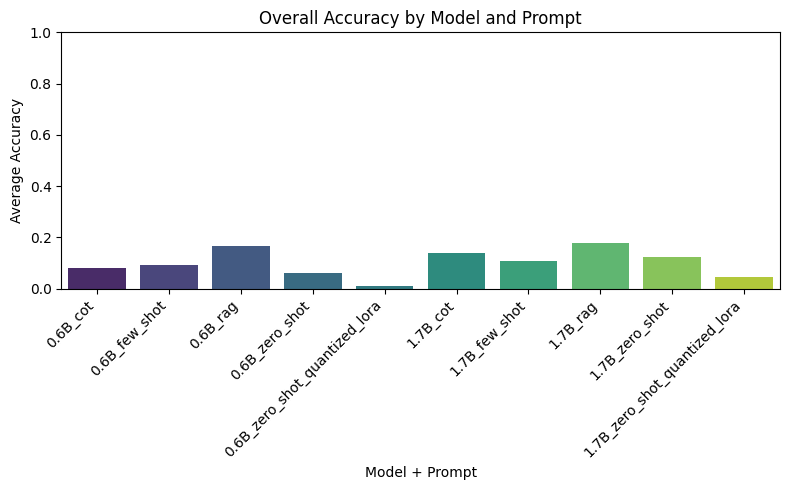

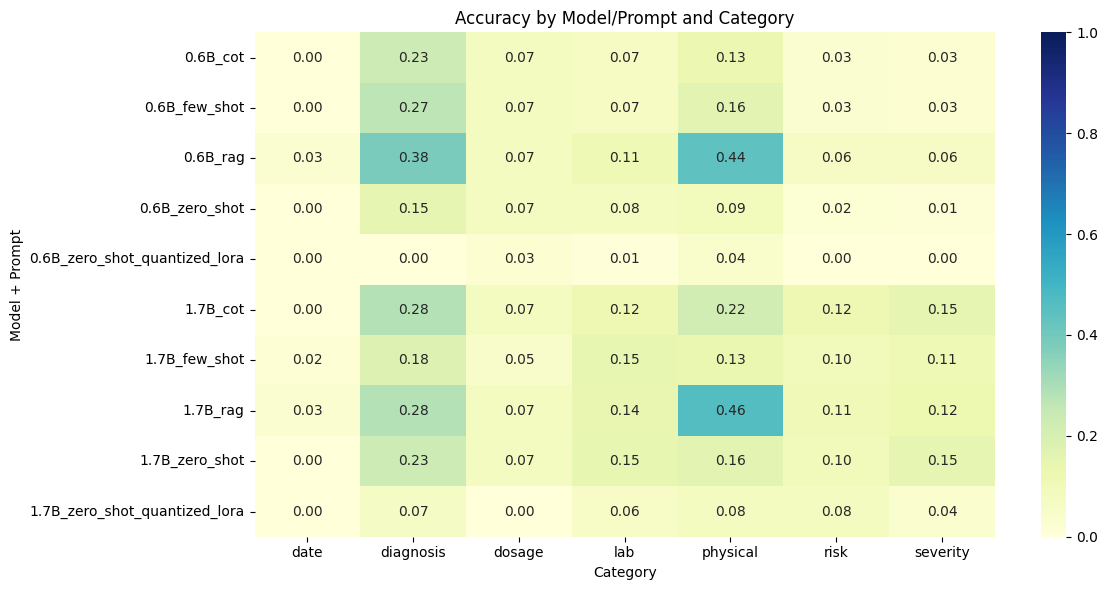

In [3]:
# Visualization: Accuracy by Model/Prompt and Category, Save as PNGs
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Ensure output directory for images exists
os.makedirs('images', exist_ok=True)

# --- Barplot: Overall Accuracy by Model/Prompt ---
if 'overall_results' in globals():
    plt.figure(figsize=(8, 5))
    sns.barplot(
        data=overall_results,
        x='Model_Prompt',
        y='Average Accuracy',
        palette='viridis'
    )
    plt.title('Overall Accuracy by Model and Prompt')
    plt.ylabel('Average Accuracy')
    plt.xlabel('Model + Prompt')
    plt.ylim(0, 1)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('images/overall_accuracy.png', dpi=200)
    plt.show()
else:
    print('overall_results not found. Please run the evaluation aggregation cell first.')

# --- Heatmap: Per-Category Accuracy by Model/Prompt ---
if 'pivot_results_df' in globals():
    # Remove 'Overall' column if present for per-category heatmap
    heatmap_data = pivot_results_df.set_index('Model_Prompt').drop(columns=['Overall'], errors='ignore')
    plt.figure(figsize=(12, 6))
    sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='YlGnBu', vmin=0, vmax=1)
    plt.title('Accuracy by Model/Prompt and Category')
    plt.ylabel('Model + Prompt')
    plt.xlabel('Category')
    plt.tight_layout()
    plt.savefig('images/category_accuracy_heatmap.png', dpi=200)
    plt.show()
else:
    print('pivot_results_df not found. Please run the evaluation aggregation cell first.')

### Saving Results

This block writes the aggregated evaluation artifacts to repository CSVs for downstream reporting and the README table:
- `aggregated_results.csv`: per-run category rows
- `overall_results.csv`: overall accuracy by Model × Method
- `pivot_results.csv`: wide table for quick viewing
- `sample_counts.csv`: counts by category
- `summary_statistics.csv`: global rollups


In [4]:
# Save aggregated results to CSV
results_df.to_csv("aggregated_results.csv", index=False)
overall_results.to_csv("overall_results.csv", index=False)
pivot_results_df.to_csv("pivot_results.csv", index=False)
sample_counts_df.to_csv("sample_counts.csv", index=False)
summary_df.to_csv("summary_statistics.csv", index=False)

print("All evaluation results saved as CSV files:")
print(" - aggregated_results.csv")
print(" - overall_results.csv")
print(" - pivot_results.csv")
print(" - sample_counts.csv")
print(" - summary_statistics.csv")


All evaluation results saved as CSV files:
 - aggregated_results.csv
 - overall_results.csv
 - pivot_results.csv
 - sample_counts.csv
 - summary_statistics.csv
